# Libraries

In [18]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict
import json

# machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# graphs
import matplotlib.pyplot as plt
import seaborn as sns

# read in data

In [45]:
market_cap_df = pd.read_csv('../data/market_cap.csv').T
# rename columns
market_cap_df.columns = market_cap_df.loc['Quarter']
# Drop the 'Quarter' row
market_cap_df.drop('Quarter', inplace=True)

In [43]:
market_cap_df.head()

Quarter,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,2011-09-30,2011-12-31,2012-03-31,2012-06-30,...,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,market_cap_start,market_cap_end
DRI,890317674.285714,912530514.285714,877013487.272727,1027599783.75,1179295768.125,1370496034.285714,1356874036.363636,1223568624.375,1372688246.769231,1525954825.16129,...,4005933975.0,3476420285.714286,2910755127.272727,2309700825.0,2128734276.923077,1821967954.83871,2217494990.769231,2853613440.0,Small-Cap,Mid-Cap
TGT,257526005.243813,228763367.960858,183409570.780622,179605926.410287,203277741.751677,222332335.162101,161783695.388166,147624484.551179,146010569.291019,158151008.409617,...,42349154.6875,36567950.793651,31262124.615385,28578404.6875,27888543.076923,27549961.290323,23274080.769231,22109128.947368,Micro-Cap,Micro-Cap
UUU,28061883.809524,25225067.741935,26727304.848485,26996773.75,24930172.5,29669404.444444,30900121.818182,28889913.75,26621592.0,27297857.419355,...,115558506.25,87482965.079365,106347793.939394,150853850.0,163661175.384615,143559658.064516,88840436.923077,86955780.0,Micro-Cap,Micro-Cap
ACWN,77688658.064516,85238219.047619,83891245.454545,85824787.5,81148528.125,81418247.619048,73921205.454545,59802084.375,69163307.076923,72964096.0,...,47773875.0,43914666.666667,35404430.769231,29135523.809524,30818584.615385,33173419.354839,32627446.153846,29545800.0,Micro-Cap,Micro-Cap
A4Y,60498724.577012,67192147.005668,64879685.030636,66598415.873479,66609234.255185,71622093.079368,77276026.413349,65710908.321486,71480993.522792,70334123.216777,...,186682062.5,145192171.428571,117039587.878788,76527987.5,68912541.538462,51401703.225806,55487372.307692,47208736.842105,Micro-Cap,Micro-Cap


# Analysis

### descriptive

In [46]:
# Function to classify companies based on market cap
def classify_market_cap(market_cap):
    if market_cap < 300000000:
        return 'Micro-Cap'
    elif 300000000 <= market_cap < 2000000000:
        return 'Small-Cap'
    elif 2000000000 <= market_cap < 10000000000:
        return 'Mid-Cap'
    elif 10000000000 <= market_cap < 200000000000:
        return 'Large-Cap'

# Get the market cap for the first and last quarter for each company
first_quarter = market_cap_df.iloc[:,0]
last_quarter = market_cap_df.iloc[:,-1]

# Classify companies based on their market cap for the first and last quarter
market_cap_df['market_cap_start'] = first_quarter.apply(classify_market_cap)
market_cap_df['market_cap_end'] = last_quarter.apply(classify_market_cap)

           First_Quarter  Last_Quarter
Large-Cap             28            41
Micro-Cap            132           144
Mid-Cap               34            56
Small-Cap             60            89


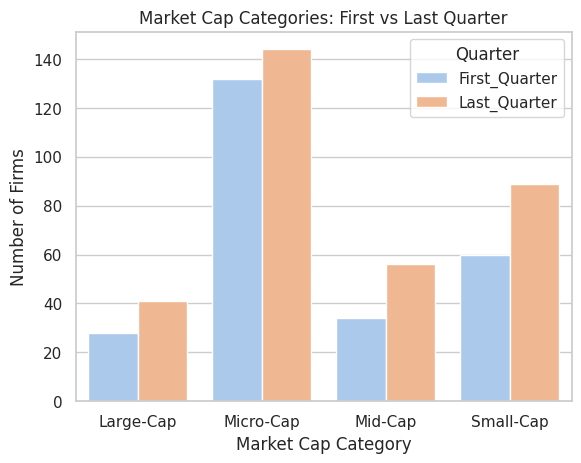

In [47]:
def count_firms_by_category(classification_series):
    return classification_series.value_counts().sort_index()

def plot_combined_firm_categories(title):
    # Combine the two Series into a DataFrame
    combined_df = pd.DataFrame({
        'First_Quarter': count_firms_by_category(market_cap_df['market_cap_start']),
        'Last_Quarter': count_firms_by_category(market_cap_df['market_cap_end'])
    }).fillna(0)  # Fill NaNs with 0
    
    print(combined_df.head())

    # Melt the DataFrame to long format for seaborn
    melted_df = combined_df.reset_index().melt(id_vars=['index'], value_vars=['First_Quarter', 'Last_Quarter'])
    
    # Set the style and palette
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create the barplot
    sns.barplot(x='index', y='value', hue='variable', data=melted_df)
    
    # Add labels and title
    plt.title(title)
    plt.xlabel('Market Cap Category')
    plt.ylabel('Number of Firms')
    plt.legend(title='Quarter', loc='upper right')
    
    # Show the plot
    plt.show()

# Usage Example
plot_combined_firm_categories('Market Cap Categories: First vs Last Quarter')


In [51]:
# Find companies whose status changed for better or worse
status_changed = market_cap_df[market_cap_df['market_cap_start'] != market_cap_df['market_cap_end']]
improved = status_changed[status_changed['market_cap_start'] < status_changed['market_cap_end']]
worsened = status_changed[status_changed['market_cap_start'] > status_changed['market_cap_end']]

print("Companies that improved:", len(improved.index.tolist()))
print("Companies that worsened:", len(worsened.index.tolist()))

Companies that improved: 44
Companies that worsened: 33


### Clustering

In [52]:
# Preprocessing: Replace NaNs and normalize the data
market_cap_df.fillna(0, inplace=True)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(market_cap_df)

# Determine the number of clusters (let's assume 3 for this example)
n_clusters = 3

# Fit the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled_data)

# Add the cluster labels back into the original DataFrame
market_cap_df['Cluster'] = kmeans.labels_

# Visualization (for the first two quarters for simplicity)
sns.scatterplot(data=market_cap_df, x='market_cap_start', y='market_cap_end', hue='Cluster')
plt.show()

ValueError: could not convert string to float: 'Small-Cap'

### ?!

# Test Area

In [16]:
market_cap_df.iloc[:,:-4].head()

Quarter,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,2011-09-30,2011-12-31,2012-03-31,2012-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31
DRI,890317674.285714,912530514.285714,877013487.272727,1027599783.75,1179295768.125,1370496034.285714,1356874036.363636,1223568624.375,1372688246.769231,1525954825.16129,...,4096546909.090909,3467203514.285715,4030969714.285715,4487879380.645162,4597045527.272727,4537926337.5,4005933975.0,3476420285.714286,2910755127.272727,2309700825.0
TGT,257526005.243813,228763367.960858,183409570.780622,179605926.410287,203277741.751677,222332335.162101,161783695.388166,147624484.551179,146010569.291019,158151008.409617,...,35377592.231028,37396485.714286,40056957.142857,40990720.967742,40648551.515152,43845084.375,42349154.6875,36567950.793651,31262124.615385,28578404.6875
UUU,28061883.809524,25225067.741935,26727304.848485,26996773.75,24930172.5,29669404.444444,30900121.818182,28889913.75,26621592.0,27297857.419355,...,63316315.151515,74710323.809524,94549053.968254,122232929.032258,126549084.848485,154449437.5,115558506.25,87482965.079365,106347793.939394,150853850.0
ACWN,77688658.064516,85238219.047619,83891245.454545,85824787.5,81148528.125,81418247.619048,73921205.454545,59802084.375,69163307.076923,72964096.0,...,37364545.454545,40642095.238095,54398285.714286,74849419.354839,70873454.545455,55405904.761905,47773875.0,43914666.666667,35404430.769231,29135523.809524
A4Y,60498724.577012,67192147.005668,64879685.030636,66598415.873479,66609234.255185,71622093.079368,77276026.413349,65710908.321486,71480993.522792,70334123.216777,...,304026696.969697,288510031.746032,276512380.952381,264699935.483871,243594909.090909,218387093.75,186682062.5,145192171.428571,117039587.878788,76527987.5
